In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yolov8/keras/yolo_v8_l_backbone/1/config.json
/kaggle/input/yolov8/keras/yolo_v8_l_backbone/1/metadata.json
/kaggle/input/yolov8/keras/yolo_v8_l_backbone/2/config.json
/kaggle/input/yolov8/keras/yolo_v8_l_backbone/2/metadata.json
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/testdata/id.jpg
/kaggle/input/myidcodetest/id2.jpg
/kaggle/input/myidcode/id.jpg
/kaggle/input/myiddata/id1.jpg


In [2]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
train_label_counts = train_df['label'].value_counts()
train_label_counts_df = train_label_counts.reset_index()
train_label_counts_df.columns = ['label', 'count']
train_label_counts_df

,label,count
0,1,4684
1,7,4401
2,3,4351
3,9,4188
4,2,4177
5,6,4137
6,0,4132
7,4,4072
8,8,4063
9,5,3795


Text(0.5, 1.0, 'Count of Each Label in Train dataset')

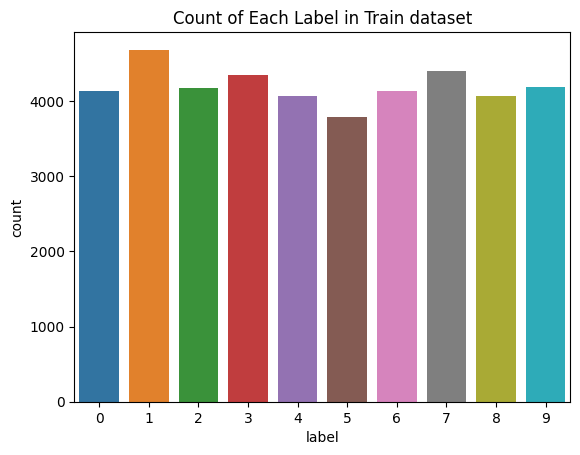

In [4]:
p1=sns.barplot(data=train_label_counts_df,x="label",y="count")
plt.title("Count of Each Label in Train dataset")

In [5]:
test_df  # 验证集仅有像素描述没有label

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def draw_image(df,index):
    image_data = df.iloc[index].values # label列不算
    image_label = image_data[0]
    image_data = image_data[1:].reshape((28,28)) # 注意是reshape而非resize
    # 绘制图片
    plt.imshow(image_data, cmap='gray')  # 使用灰度颜色映射
    plt.title(f'Digital number {image_label}')
    plt.colorbar()  # 添加颜色条
    plt.show()

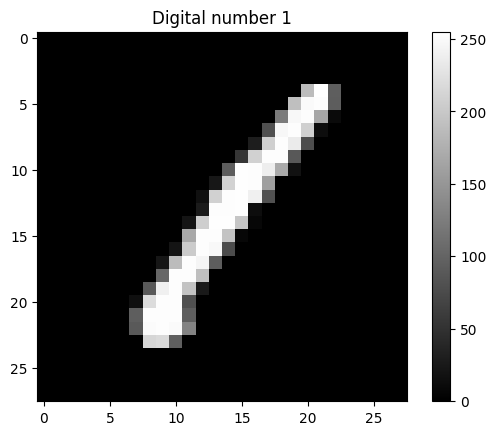

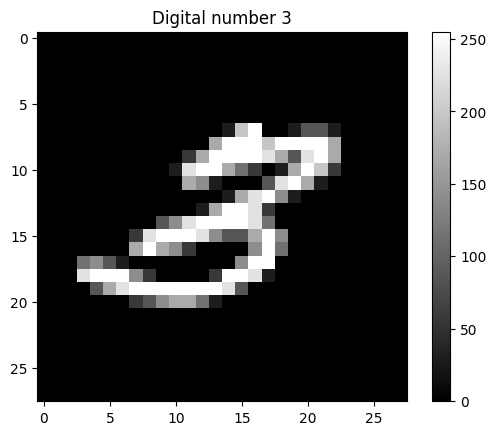

In [7]:
draw_image(train_df,0)
draw_image(train_df,1050)

In [8]:
from sklearn.model_selection import train_test_split
X = train_df.drop('label',axis=1)
y = train_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset,RandomSampler
import torchvision
from torchvision import datasets, models, transforms

In [11]:
X_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.reshape(28, 28)), 
    
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
])

In [12]:
data_test = X_transforms(X_val.iloc[0].values).to(device)
data_test.shape

torch.Size([1, 28, 28])

In [13]:
class MnistDataset(Dataset):
    def __init__(self,data,labels,transforms):
        self.data = data
        self.labels = labels
        self.transforms = transforms
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Pandas DataFrame，将其转换为 PyTorch 张量
        if isinstance(self.data, pd.DataFrame):
            if self.transforms:
                data_item = self.transforms(self.data.iloc[idx].values)
        else:
            data_item = self.data[idx]
        label_item = torch.tensor(self.labels.values[idx], dtype=torch.long)

        return data_item, label_item

In [14]:
train_dataset = MnistDataset(X_train,y_train,X_transforms)
val_dataset = MnistDataset(X_val,y_val,X_transforms)
train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)

In [15]:
train_dataloader = DataLoader(train_dataset,batch_size=64,sampler=train_random_sampler)
val_dataloader = DataLoader(val_dataset,batch_size=64,sampler=val_random_sampler)

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [17]:
device

'cuda'

In [17]:
!pip install netron

  Obtaining dependency information for netron from https://files.pythonhosted.org/packages/69/6a/d058fad5d666ef5ee70b39d3e29a4573d74b18a6bd4ca358436ff6d5fe13/netron-7.3.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.7 MB/s eta 0:00:0000:0100:010m


In [18]:
import torch.nn.functional as F
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.c1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.c2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        x = self.relu(self.bn1(self.c1(x)))
        x = self.max_pool2d(x)
        x = self.relu(self.bn2(self.c2(x)))
        x = self.max_pool2d(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)  # 使用softmax作为输出层激活函数
        return x
        

In [9]:
mynet = MyNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mynet.parameters(), lr=0.001)

In [18]:
numepochs = 15

In [19]:
from tqdm import tqdm

In [20]:
loop = tqdm(range(numepochs))
best_val_acc = -1
for epoch in loop:
    mynet.train()  # 训练模型
    losses = []
    accuracy = []
    for (data,labels) in train_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 梯度清零
        outputs = mynet(data)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        _,predictions = outputs.max(1) # 选择最大的
#         print(predictions,labels)
        num_correct = (predictions == labels).sum()
        batch_train_acc = float(num_correct)/ float(data.shape[0])
        accuracy.append(batch_train_acc)
        optimizer.step()
        loop.set_description(f'Epoch {epoch}/{numepochs}:')
        loop.set_postfix(loss=loss.item(),acc=batch_train_acc)
    # 在测试集上评估模型
    mynet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in val_dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = mynet(data)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    if accuracy > best_val_acc:
        tqdm.write("save best model")
        torch.save(mynet,"best_model1.pth")
        best_val_acc = accuracy
    tqdm.write(f"Epoch {epoch+1}/{numepochs}, val Accuracy: {accuracy:.4f}")

Epoch 1/15::   7%|▋         | 1/15 [00:09<02:15,  9.71s/it, acc=0.812, loss=1.66]

save best model
Epoch 1/15, val Accuracy: 0.9610


Epoch 2/15::  13%|█▎        | 2/15 [00:18<01:59,  9.18s/it, acc=0.891, loss=1.57]

save best model
Epoch 2/15, val Accuracy: 0.9715


Epoch 3/15::  20%|██        | 3/15 [00:27<01:48,  9.06s/it, acc=0.812, loss=1.64]

Epoch 3/15, val Accuracy: 0.9663


Epoch 4/15::  27%|██▋       | 4/15 [00:36<01:38,  8.92s/it, acc=0.922, loss=1.57]

save best model
Epoch 4/15, val Accuracy: 0.9737


Epoch 5/15::  33%|███▎      | 5/15 [00:45<01:28,  8.84s/it, acc=0.875, loss=1.58]

save best model
Epoch 5/15, val Accuracy: 0.9738


Epoch 6/15::  40%|████      | 6/15 [00:53<01:19,  8.83s/it, acc=0.891, loss=1.56]

save best model
Epoch 6/15, val Accuracy: 0.9773


Epoch 7/15::  47%|████▋     | 7/15 [01:02<01:10,  8.81s/it, acc=0.938, loss=1.54]

save best model
Epoch 7/15, val Accuracy: 0.9810


Epoch 8/15::  53%|█████▎    | 8/15 [01:11<01:01,  8.77s/it, acc=0.938, loss=1.54]

Epoch 8/15, val Accuracy: 0.9693


Epoch 9/15::  60%|██████    | 9/15 [01:19<00:52,  8.74s/it, acc=0.938, loss=1.53]

Epoch 9/15, val Accuracy: 0.9802


Epoch 10/15::  67%|██████▋   | 10/15 [01:28<00:43,  8.77s/it, acc=0.938, loss=1.52]

Epoch 10/15, val Accuracy: 0.9792


Epoch 11/15::  73%|███████▎  | 11/15 [01:37<00:34,  8.74s/it, acc=0.922, loss=1.55]

save best model
Epoch 11/15, val Accuracy: 0.9815


Epoch 12/15::  80%|████████  | 12/15 [01:46<00:26,  8.73s/it, acc=0.953, loss=1.51]

Epoch 12/15, val Accuracy: 0.9796


Epoch 13/15::  87%|████████▋ | 13/15 [01:54<00:17,  8.74s/it, acc=0.875, loss=1.58]

save best model
Epoch 13/15, val Accuracy: 0.9831


Epoch 14/15::  93%|█████████▎| 14/15 [02:03<00:08,  8.71s/it, acc=0.938, loss=1.53]

Epoch 14/15, val Accuracy: 0.9829


Epoch 14/15:: 100%|██████████| 15/15 [02:12<00:00,  8.80s/it, acc=0.891, loss=1.58]

Epoch 15/15, val Accuracy: 0.9827


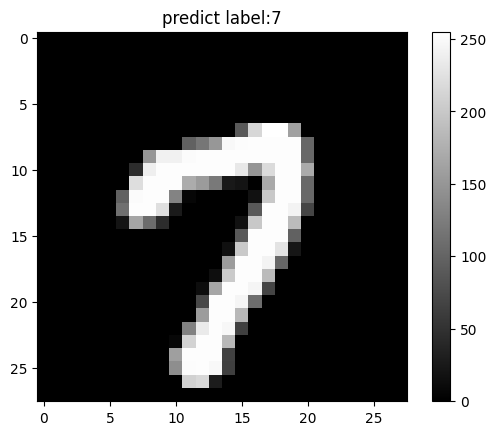

In [19]:
mynet = torch.load("/kaggle/working/best_model1.pth")
mynet.eval()
index = 92
data_test = X_transforms(X_val.iloc[index].values).to(device)
data_test
label = y_val.values[index]
out_put = mynet(data_test.unsqueeze(0))
_,predictions = out_put.max(1) # 选择最大的
pred_label = predictions[0]
image_data = X_val.iloc[index].values.reshape((28,28)) # 注意是reshape而非resize
# 绘制图片
plt.imshow(image_data, cmap='gray')  # 使用灰度颜色映射
plt.title(f'predict label:{pred_label}')
plt.colorbar()  # 添加颜色条
plt.show()

In [20]:
import cv2

In [21]:
img_dir = "/kaggle/input/myidcodetest/id2.jpg"
image = cv2.imread(img_dir,cv2.IMREAD_GRAYSCALE)

In [ ]:
import keras_cv
import keras_core as keras
import tensorflow as tf
resized_image = image
normalized_image = resized_image / 255.0  # Normalize pixel values to the range [0, 1]

# Expand dimensions to create a batch (assuming your model expects a batch of images)
input_data = np.repeat(np.expand_dims(normalized_image, axis=-1), 3, axis=-1)

# Expand dimensions to create a batch
input_data = np.expand_dims(input_data, axis=0)

output = model(input_data).numpy()

# Reshape the output to match YOLOv8 structure
grid_size = output.shape[1]
num_anchors = 3  # Adjust based on the number of anchors in your YOLOv8 model
num_classes = 80  # Adjust based on the number of classes in your YOLOv8 model
output = np.reshape(output, (-1, grid_size, grid_size, num_anchors, 5 + num_classes))

# Extract bounding boxes, scores, and classes
boxes = output[..., :4]
confidences = output[..., 4:5]
class_probs = output[..., 5:]

# Combine confidences with class probabilities
scores = confidences * class_probs

# Find the class with the highest score for each box
predicted_classes = np.argmax(scores, axis=-1)

# Filter out boxes with low confidence scores
mask = scores >= 0.5  # You can adjust the confidence threshold as needed
filtered_boxes, filtered_scores, filtered_classes = [], [], []
for i in range(len(boxes)):
    indices = np.where(mask[i])
    filtered_boxes.append(boxes[i, indices])
    filtered_scores.append(scores[i, indices])
    filtered_classes.append(predicted_classes[i, indices])

# Draw bounding boxes on the original image
image_with_boxes = resized_image.copy()

# Iterate over detected objects
for box, score, class_id in zip(filtered_boxes[0], filtered_scores[0], filtered_classes[0]):
    x, y, width, height = box.astype(int)
    confidence = float(score)
    class_name = keras_cv.models.YOLOV8_CLASSES[class_id]

    # Draw bounding box
    color = (0, 255, 0)  # Green color
    image_with_boxes = cv2.rectangle(image_with_boxes, (x, y), (width, height), color, 2)

    # Add label with confidence and class name
    label = f"{class_name}: {confidence:.2f}"
    image_with_boxes = cv2.putText(image_with_boxes, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the image with bounding boxes using Matplotlib
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [22]:
image.shape

(153, 788)

In [23]:
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm
import matplotlib.patches as patches

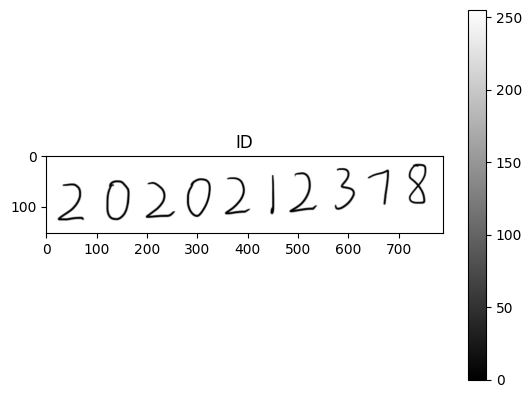

In [24]:

plt.imshow(image, cmap='gray')  # 使用灰度颜色映射
plt.title(f'ID')
plt.colorbar()  # 添加颜色条
plt.show()

In [25]:
unique_values, counts = np.unique(image.flatten(), return_counts=True)

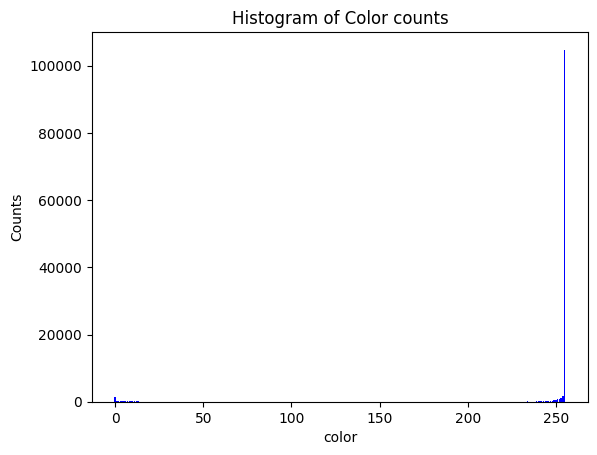

In [26]:
# 绘制柱状图
plt.bar(unique_values, counts, color='blue')
plt.xlabel('color')
plt.ylabel('Counts')
plt.title('Histogram of Color counts')
plt.show()

In [27]:
x_histogram = np.sum(image,axis=0)

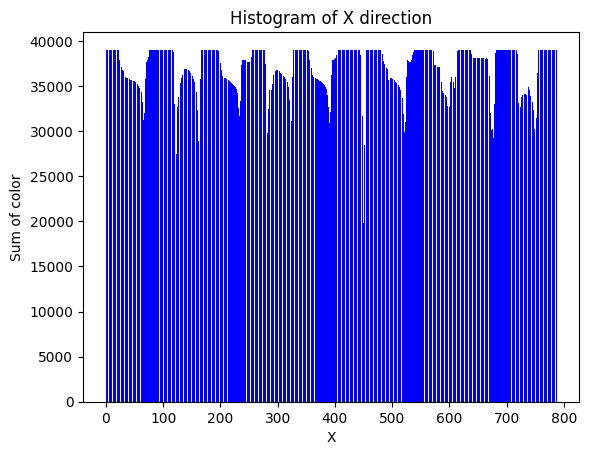

In [28]:
bottom = np.min(x_histogram)
# 绘制柱状图
plt.bar(np.arange(x_histogram.shape[0]), x_histogram, color='blue')
plt.xlabel('X')
plt.ylabel('Sum of color')
plt.title('Histogram of X direction')
plt.show()

In [29]:
def find_vally(histogram,top_wave,threshold=10):
    # 找到波谷区间
    vally_res = []
    start = 0
    end = 0
    ischange = False
    for index,h in tqdm(enumerate(histogram)):
        if h == top_wave:
            if ischange:
                end = index
                if end - start < threshold:
                    ischange=False
                    continue   # 数字长度不可能小于threshold个像素
                vally_res.append([start,end])
                ischange = False
        else:
            if not ischange:
                ischange = True
                start = index
    return vally_res
                

In [30]:
x_vally = find_vally(x_histogram,np.max(x_histogram))

788it [00:00, 770601.90it/s]


In [31]:
x_vally,len(x_vally)

([[16, 80],
  [112, 168],
  [192, 264],
  [272, 328],
  [352, 408],
  [440, 456],
  [480, 544],
  [568, 616],
  [632, 688],
  [712, 760]],
 10)

In [32]:
def get_boxes(Xvally,image_src):
    boxes = []
    for x_v in Xvally:
        x_image = image_src[:,x_v[0]:x_v[1]]
        y_part_histogram = np.sum(x_image,axis=1)
        
        y_vally = find_vally(y_part_histogram,np.max(y_part_histogram),20)
        for y_v in y_vally:
            boxes.append([x for x in x_v]+[y for y in y_v])
    return boxes

In [33]:
boxes = get_boxes(x_vally,image)

153it [00:00, 517105.97it/s]
153it [00:00, 543837.72it/s]
153it [00:00, 755863.97it/s]
153it [00:00, 754974.72it/s]
153it [00:00, 586053.44it/s]
153it [00:00, 565399.57it/s]
153it [00:00, 775971.60it/s]
153it [00:00, 618831.74it/s]
153it [00:00, 560951.50it/s]
153it [00:00, 543837.72it/s]


In [34]:
boxes

[[16, 80, 48, 136],
 [112, 168, 48, 134],
 [192, 264, 48, 128],
 [272, 328, 40, 128],
 [352, 408, 40, 120],
 [440, 456, 32, 120],
 [480, 544, 32, 120],
 [568, 616, 24, 112],
 [632, 688, 24, 104],
 [712, 760, 16, 100]]

In [35]:
def draw_boxes_on_image(image_src,boxes):
    plt.imshow(image_src, cmap='gray')  # 使用灰度颜色映射
    plt.title(f'ID')
    plt.colorbar()  # 添加颜色条
    for box in boxes:
        currentAxis=plt.gca()
        rect=patches.Rectangle((min(box[0],box[1]), min(box[2],box[3])),abs(box[0]-box[1]),abs(box[2]-box[3]),linewidth=1,edgecolor='r',facecolor='none')
        currentAxis.add_patch(rect)
    plt.show()

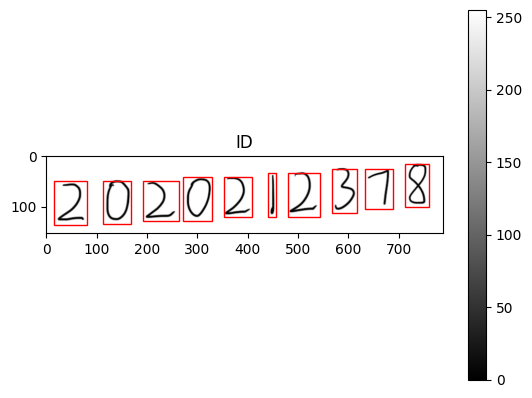

In [36]:
draw_boxes_on_image(image,boxes)

In [37]:
def get_boxes_from_image(image_src):
    x_histogram = np.sum(image_src,axis=0)
    x_vally = find_vally(x_histogram,np.max(x_histogram))
    boxes = get_boxes(x_vally,image_src)
    return boxes

In [38]:
def get_box_image(image_src,box):
    # 获取box区域的数字图像
    box_image = image_src[box[2]:box[3],box[0]:box[1]]
#     plt.imshow(box_image, cmap='gray')  # 使用灰度颜色映射
#     plt.title(f'number')
#     plt.colorbar()  # 添加颜色条
#     plt.show()
    return box_image

In [54]:
def draw_boxes_on_image_with_label(image_src, boxes, labels):
    plt.imshow(image_src, cmap='gray')  # Use grayscale color map
    plt.title('')
    plt.colorbar()  # Add color bar

    for box, label in zip(boxes, labels):
        currentAxis = plt.gca()
        rect = patches.Rectangle(
            (min(box[0], box[1]), min(box[2], box[3])),
            abs(box[0] - box[1]),
            abs(box[2] - box[3]),
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        currentAxis.add_patch(rect)

        # Display label near the box
        plt.text(box[0], box[2], f'{label}', color='r', fontsize=32, verticalalignment='bottom')

    plt.show()

In [40]:
def predict(image,boxes):
    fig, axs = plt.subplots(1, len(boxes), figsize=(15, 5))
    image_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.reshape(28, 28,1)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
    ])
    result = []
    for i,box in enumerate(boxes):
        box_image = get_box_image(image,box)
        box_image_resize = cv2.resize(box_image,(20,20))
        box_image_resize = 255 - box_image_resize
        # 新图像大小
        target_size = (28, 28)
        original_size = (20,20)
        # 创建一个全零的目标大小的图像
        new_image = np.zeros(target_size)

        # 将原始图像粘贴到新图像中心
        x_offset = (target_size[0] - original_size[0]) // 2
        y_offset = (target_size[1] - original_size[1]) // 2

        # 在新图像上粘贴原始图像
        new_image[x_offset:x_offset + original_size[0], y_offset:y_offset + original_size[1]] = box_image_resize
        box_image_final = new_image
        mynet.eval()
        data_test = image_transforms(box_image_final).to(device)
        out_put = mynet(image_transforms(box_image_final).unsqueeze(0).float().to(device))
        _,predictions = out_put.max(1) # 选择最大的
#         print(out_put)
        pred_label = predictions[0]
        result.append(int(pred_label))
        # 绘制图片
        # 在子图上绘制图像
        axs[i].imshow(box_image_final, cmap='gray')
        axs[i].set_title(f'predict {pred_label}')
        axs[i].axis('off')  # 关闭坐标轴
    
    plt.show()
    print(f"学号是：{''.join([str(i) for i in result])}")
    return result

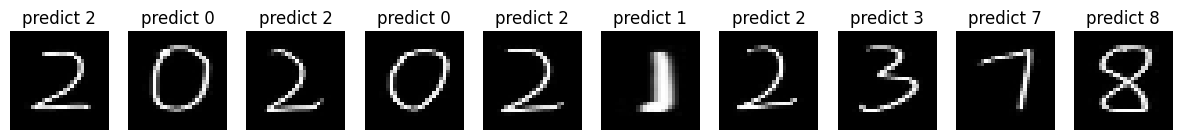

学号是：2020212378


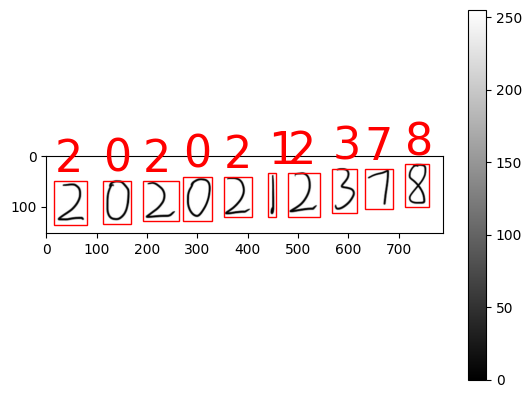

In [55]:
result = predict(image,boxes)
draw_boxes_on_image_with_label(image, boxes, result)

In [43]:
box_image = get_box_image(image,boxes[9])

In [44]:
box_image_resize = cv2.resize(box_image,(20,20))
box_image_resize = 255 - box_image_resize
# 新图像大小
target_size = (28, 28)
original_size = (20,20)
# 创建一个全零的目标大小的图像
new_image = np.zeros(target_size)

# 将原始图像粘贴到新图像中心
x_offset = (target_size[0] - original_size[0]) // 2
y_offset = (target_size[1] - original_size[1]) // 2

# 在新图像上粘贴原始图像
new_image[x_offset:x_offset + original_size[0], y_offset:y_offset + original_size[1]] = box_image_resize
box_image_final = new_image

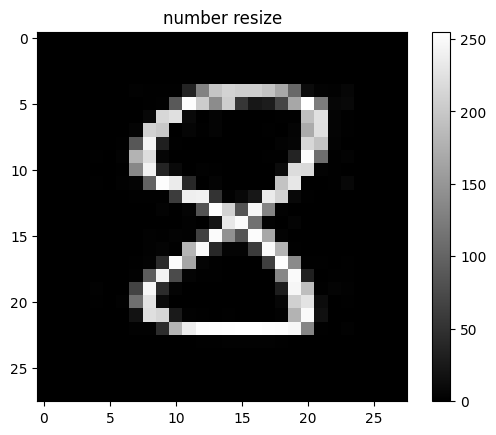

In [45]:
plt.imshow(box_image_final, cmap='gray')  # 使用灰度颜色映射
plt.title(f'number resize')
plt.colorbar()  # 添加颜色条
plt.show()

In [46]:
image_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.reshape(28, 28,1)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
])

tensor([[0.0000e+00, 2.8026e-45, 2.8022e-34, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


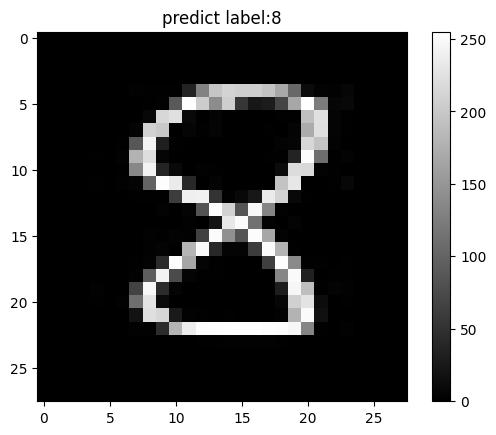

In [47]:
mynet.eval()
data_test = image_transforms(box_image_final).to(device)
out_put = mynet(image_transforms(box_image_final).unsqueeze(0).float().to(device))
_,predictions = out_put.max(1) # 选择最大的\
print(out_put)
pred_label = predictions[0]
# 绘制图片
plt.imshow(box_image_final, cmap='gray')  # 使用灰度颜色映射
plt.title(f'predict label:{pred_label}')
plt.colorbar()  # 添加颜色条
plt.show()

In [48]:
pred_label

tensor(8, device='cuda:0')